# Quantum Optimal Control

The quantum fidelity of a quantum gate, as calculated in the simulation, can
be used as figure of merit in an optimization algorithm in order to find a
control pulse that implements a quantum gate with minimal infidelity.

Let's consider again a single qubit under Rabi-driving:


In [1]:
import numpy as np
from qopt import *


sigma_x = DenseOperator.pauli_x()
sigma_y = DenseOperator.pauli_y()
sigma_z = DenseOperator.pauli_z()
zero_matrix = DenseOperator(np.zeros((2, 2)))

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

n_time_steps = 5
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps
)
solver.set_optimization_parameters(0 * control_amplitudes)

entanglement_infidelity = OperationInfidelity(
    solver=solver,
    target=sigma_x
)

The Simulator class defines an interface between the simulation and the
optimization algorithm.

The simulator class holds a list of cost functions and solvers. Every time the cost functions are evaluated, all simulators will be updated. This is convenient to minimize numerous error sources at once.

In [2]:
simulator = Simulator(
    solvers=[solver, ],
    cost_funcs=[entanglement_infidelity, ]
)

The actual optimization algorithm is controlled by the class Optimizer. We
use the least squares optimization of scipy.

In [3]:
termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 100,
    "min_amplitude_change": 1e-8
}

upper_bounds = 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

The bounds mark the range in which the optimization algorithm shall search for
an optimum. As initial values, we use a random pulse.

In [4]:
np.random.seed(0)
initial_pulse = np.pi * np.random.rand(n_time_steps, len(h_ctrl))

result = optimizer.run_optimization(initial_control_amplitudes=initial_pulse)

Next we initialize a data container to store the information gained in the
optimization. The DataContainer class is instantiated with a storage path
and file name, where the data can be stored.


In [5]:
data_container = DataContainer(
    storage_path=r'..\..\..\temp',
    file_name="File Name"
)

data_container.append_optim_result(optim_result=result)
analyser = Analyser(data=data_container)

The data container class is used to gather the information of multiple
optimization runs and can be used to write data to and load it from the hard
drive.

The Analyser gives access to some convenience functions to plot the cost
function evaluations during the optimization run.


<AxesSubplot:xlabel='Iteration', ylabel='Costs'>

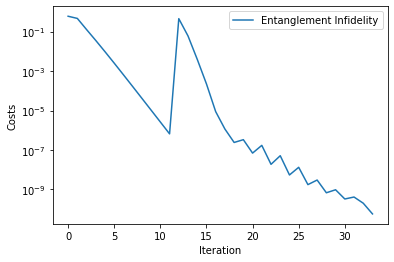

In [6]:
analyser.plot_costs()

In the plotted costs, we can observe the expected linear convergence for
newton-like optimization algorithms.

The Data container allows also to pickle the gathered data for later analysis.


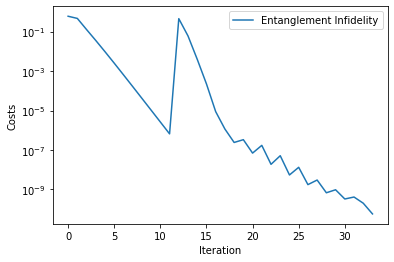

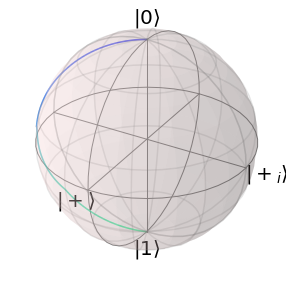

In [7]:
data_container.to_pickle()
loaded_data = DataContainer.from_pickle(r'..\..\..\temp\File Name')

analyser = Analyser(loaded_data)
analyser.plot_costs()
solver.set_optimization_parameters(loaded_data.final_parameters[0])
solver.plot_bloch_sphere()